# Simple example of a WeatherBench model

In this notebook we will build a simple neural network on the WeatherBench dataset. We will walk you through all the code so if you are not familiar with python you can simply click through the code boxes (see "How to run this exercise" below). If you are familiar with python and machine learning, there is a stretch exercise at the end of the notebook.

The aim of this example is to predict the geopotential at the 500hPa pressure level in the atmosphere and compare your solution with the benchmark dataset. This variable is important for identifying weather systems such as cyclones and anticyclones.

With the data you will download, you can make a forecast for any number of days ahead, but in this exercise we focus on forecasting the geopotential five days ahead.

We evaluate our model using the Root Mean Squared Error.

## How to run this exercise

This exercise is in the form of a [Jupyter notebook](https://jupyter.org/). It can be "run" in a number of free cloud based environments (see two options below). These require no installation. When you click on one of the links below ("Open in Colab" or "Open in Kaggle") you will be prompted to create a free account, after which you will see the same page you see here. Follow the instructions below to connect to a GPU. After that you can run each block of code by selecting shift+control repeatedly, or by selecting the "play" icon.

Advanced users may wish to run this exercise on their own computers by first installing Python and Jupyter, in addition to the packages listed below (xarray, numpy and tensorflow), or as listed in the "environment.yml" file in https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/tree/main/tier_1.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
  </tr>
</table>

Note that to use Kaggle, you need to enable an option on the notebook. Please follow the instructions here to do this https://stackoverflow.com/questions/68142524/cannot-access-internet-on-kaggle-notebook.

Since we will train a neural network later, it might make sense to connect to a GPU runtime:

*   In Google Colab this can be done under Runtime --> Change runtime type.

*   In Kaggle this can be done under Accelerator.

## Import packages

Below is the very first code block to "run". This will import software packages needed to run the exercise. They include [numpy](https://numpy.org/doc/stable/) and [xarray](https://docs.xarray.dev/en/stable/), which are used for handling multidimentional arrays of data. They also include [tensorflow](https://www.tensorflow.org/) which is a popular Machine Learning package.

In [3]:
# Import packages
import xarray as xr
import numpy as np

## Load in the necessary python packages to train a neural network

import tensorflow.keras as keras
import tensorflow as tf

## Download data

We need to download the WeatherBench data from the public repository. We will only download the 500hPa geopotential data at 5.625 degrees, because training on the whole benchmark dataset using colab would take a very long time and is thus beyond the scope of this exercise.

#### Note this download may take over 20 minutes.

In [4]:
try:
    !wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
except:
    !wget --no-check-certificate "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

--2024-03-11 17:05:57--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.238.204
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.238.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532774663 (1.4G) [application/zip]
Saving to: ‘geopotential_500_5.625deg.zip’

geopotential_500_5. 100%[===================>]   1.43G  2.25MB/s    in 11m 7s  

2024-03-11 17:17:05 (2.19 MB/s) - ‘geopotential_500_5.625deg.zip’ saved [1532774663/1532774663]



In [5]:
# Unzip the data
!unzip geopotential_500_5.625deg.zip

Archive:  geopotential_500_5.625deg.zip
  inflating: geopotential_500hPa_1979_5.625deg.nc  
  inflating: geopotential_500hPa_1980_5.625deg.nc  
  inflating: geopotential_500hPa_1981_5.625deg.nc  
  inflating: geopotential_500hPa_1982_5.625deg.nc  
  inflating: geopotential_500hPa_1983_5.625deg.nc  
  inflating: geopotential_500hPa_1984_5.625deg.nc  
  inflating: geopotential_500hPa_1985_5.625deg.nc  
  inflating: geopotential_500hPa_1986_5.625deg.nc  
  inflating: geopotential_500hPa_1987_5.625deg.nc  
  inflating: geopotential_500hPa_1988_5.625deg.nc  
  inflating: geopotential_500hPa_1989_5.625deg.nc  
  inflating: geopotential_500hPa_1990_5.625deg.nc  
  inflating: geopotential_500hPa_1991_5.625deg.nc  
  inflating: geopotential_500hPa_1992_5.625deg.nc  
  inflating: geopotential_500hPa_1993_5.625deg.nc  
  inflating: geopotential_500hPa_1994_5.625deg.nc  
  inflating: geopotential_500hPa_1995_5.625deg.nc  
  inflating: geopotential_500hPa_1996_5.625deg.nc  
  inflating: geopotentia

Next we open the dataset using xarray. We will also, for the sake of speed and simplicity, load data only every 12 hours.

In [6]:
z500 = xr.open_mfdataset('geopotential_500*.nc', combine='by_coords').isel(time=slice(None, None, 12))
z500

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 29220)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [7]:
# Now we can load the data into memory to speed up accessing data. This should take <30s
z500.load()

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 29220)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 5.156e+04 5.158e+04 ... 4.864e+04
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

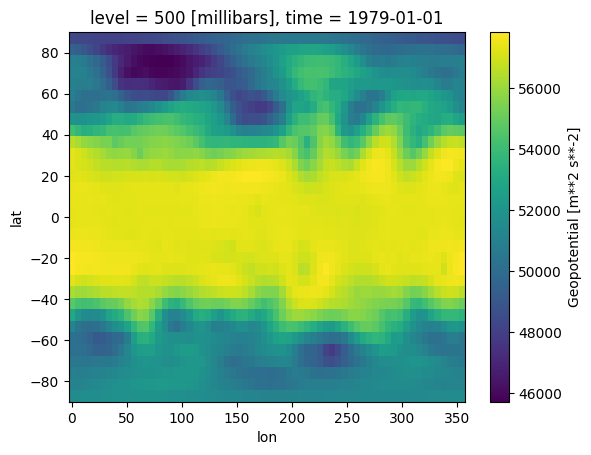

In [8]:
# Plot the geopotential at an example date-time
z500.z.isel(time=0).plot();

## Compute baselines

Before training an ML model it is important to have some baselines. Here, we will compute a climatology baseline. For this, we will use the training time period (1979 to 2015) and compute a climatology for each day of the year.

In [9]:
# training dataset selection
train_years = slice('1979', '2015')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2016', '2016')
# test dataset selection
test_years = slice('2017', '2018')

In [10]:
def computed_weighted_rmse(fc, gt):
  """Error metric to compute the area averaged RMSE."""
  error = fc - gt
  print("error",error)
  weights_lat = np.cos(np.deg2rad(error.lat))
  weights_lat /= weights_lat.mean()
  rmse = np.sqrt(((error)**2 * weights_lat).mean(('time', 'lat', 'lon')))
  return rmse

Here we consider two baselines: the persistence and the climatology. The persistence is calculated as follows:

In [11]:
# pick the forecast lead time
lead_time_steps = 10 # 5 day forecast because considering midday and midnight
print("="*100)
print("TEST DATA",z500.sel(time=test_years).isel(time=slice(0,-1)))
print("="*100)
# compute persistent forecast
persistence_fc = z500.sel(time=test_years).isel(time=slice(0, -lead_time_steps))
print("="*100)
print("persistence_fc)",persistence_fc)
print("="*100)
persistence_fc['time'] = persistence_fc.time + np.timedelta64(5, 'D').astype('timedelta64[ns]')
print("="*100)
print("shifted persistence_fc)",persistence_fc)
print("="*100)
print("="*100)
print("Value of shifted TEST DATA",z500.sel(time=test_years).isel(time=slice(10,-1)))
print("="*100)

# target data
target = z500.sel(time=test_years)['z']
# compute RMSE
rmse = computed_weighted_rmse(persistence_fc, target)
print("="*100)
print("RMSE",rmse)
rmse
print("="*100)

TEST DATA <xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 1459)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T12:00:00 ... 2018-12-31
Data variables:
    z        (time, lat, lon) float32 5.095e+04 5.098e+04 ... 4.848e+04
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...
persistence_fc) <xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 1450)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-26T12:00:00
Data variables:
    z        (time, lat, lon) float32 5.095e+04 5.098e+04 ... 4.701e+04
Attributes:
    Conventions

The climatology is calculated for each day of year from the training time period

In [12]:
clim = z500.sel(time=train_years).groupby('time.dayofyear').mean()
# compute RMSE
computed_weighted_rmse(clim.sel(dayofyear=z500.sel(time=test_years).time.dt.dayofyear), z500)

error <xarray.Dataset>
Dimensions:    (lon: 64, lat: 32, time: 1460)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
    level      int32 500
    dayofyear  (time) int64 1 1 2 2 3 3 4 4 ... 362 362 363 363 364 364 365 365
Data variables:
    z          (time, lat, lon) float32 -574.8 -585.1 ... 1.246e+03 1.32e+03


/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 819.9

## Train a simple CNN

Now we can train a simple convolutional neural network. We will use Keras for this. First though we need to prepare the data.

In [13]:
def get_train_valid_test_dataset(lead_steps, z500_dataset):
  # Split train, valid and test dataset
  train_data = z500_dataset.sel(time=train_years)
  valid_data = z500_dataset.sel(time=valid_years)
  test_data = z500_dataset.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  mean = mean['z'].values # extract numerical value from xarray Dataset
  std = std['z'].values # extract numerical value from xarray Dataset

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [14]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, z500)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(27018, 32, 64, 1)
(27018, 32, 64, 1)
(722, 32, 64, 1)
(722, 32, 64, 1)
(1450, 32, 64, 1)
(1450, 32, 64, 1)


### Build model

Next we will build the model using Keras. There are many guides for Keras out there, for example [this](https://keras.io/examples/vision/mnist_convnet/). Here we will build a convolutional neural network which we briefly discussed at the end of the module

In [15]:
# CNN

model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same'),   # 32 channels with a 5x5 convolution
    keras.layers.ELU(),  # Slightly smoother alternative to ReLU
    keras.layers.Conv2D(32, 5, padding='same'),   # Same padding keeps the size identical.
    keras.layers.ELU(),
    keras.layers.Conv2D(1, 5, padding='same'),
    # No activation since we are solving a regression problem
])

Next we need to build the model using an example batch and compile it. As an optimizer we will use the standard Adam optimizer combined with a Mean Squared Error Loss. Details on the Adam optimizer can be found here: Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

In [16]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(1e-4), 'mse')

In [17]:
# With .summary() we can check the shape of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 32, 64, 32)          832       
                                                                 
 elu (ELU)                   (32, 32, 64, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 32, 64, 32)          25632     
                                                                 
 elu_1 (ELU)                 (32, 32, 64, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (32, 32, 64, 1)           801       
                                                                 
Total params: 27265 (106.50 KB)
Trainable params: 27265 (106.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Finally we can fit the model.
# For each epoch, the entire training dataset has passed through the neural network exactly once
# Each epoch should take about 10s

model.fit(X_train, Y_train, batch_size=32, epochs=15)

Epoch 1/15
845/845 [==============================] - 10s 7ms/step - loss: 0.1093
Epoch 2/15
845/845 [==============================] - 6s 7ms/step - loss: 0.0871
Epoch 3/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0861
Epoch 4/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0855
Epoch 5/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0851
Epoch 6/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0847
Epoch 7/15
845/845 [==============================] - 6s 7ms/step - loss: 0.0845
Epoch 8/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0842
Epoch 9/15
845/845 [==============================] - 6s 7ms/step - loss: 0.0840
Epoch 10/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0839
Epoch 11/15
845/845 [==============================] - 6s 7ms/step - loss: 0.0838
Epoch 12/15
845/845 [==============================] - 5s 6ms/step - loss: 0.0836
Epoch 13/15
845/845 [===

In [19]:
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()   # To remove channel dimension which is 1

46/46 [==============================] - 0s 3ms/step


For network training we normalized the data by subtracting the mean and dividing by the standard deviation. To evaluate the predictions, we now need to un-normalize the data using the mean and standard deviation we used to normalize it. Then we can compute the RMSE of the predictions.

In [20]:
# Unnormalize
pred_test = pred_test * std + mean
# compute RMSE
computed_weighted_rmse(pred_test, target.isel(time=slice(lead_time_steps, None)))

error <xarray.DataArray 'z' (time: 1450, lat: 32, lon: 64)>
array([[[-3.66914062e+01, -2.23820312e+02, -2.35253906e+02, ...,
         -2.97039062e+02, -2.14828125e+02, -2.59593750e+02],
        [ 4.39519531e+02,  2.50570312e+02,  1.86449219e+02, ...,
          6.08136719e+02,  3.75140625e+02,  3.82261719e+02],
        [ 3.95019531e+02,  4.39914062e+02,  4.40070312e+02, ...,
          5.36343750e+02,  2.94328125e+02,  2.41605469e+02],
        ...,
        [ 2.89453125e+00, -1.51359375e+02, -3.36203125e+02, ...,
          1.70553516e+03,  1.59803906e+03,  1.47658594e+03],
        [ 1.50481641e+03,  1.49123828e+03,  1.33797656e+03, ...,
          2.15039844e+03,  2.26130469e+03,  2.23216797e+03],
        [ 1.97271875e+03,  1.87323438e+03,  1.70939844e+03, ...,
          2.32368359e+03,  2.50248047e+03,  2.69196484e+03]],

       [[ 9.00507812e+01, -1.32250000e+02, -1.51402344e+02, ...,
         -1.59000000e+02, -6.67851562e+01, -9.10039062e+01],
        [ 2.57820312e+02,  9.87968750e+01, 

<xarray.DataArray ()>
array(823.60227612)
Coordinates:
    level    int32 500

How does the skill compare to the climatology?

It is always important to visualize your models predictions. Here we take a time from the test period and visualize the ground truth, the climatology and the neural networks' predictions. What do you notice? How about if you try a different time?

PRED XARRAY <xarray.DataArray 'z' (time: 1450, lat: 32, lon: 64)>
array([[[50594.734, 50617.72 , 50640.688, ..., 50533.484, 50548.797,
         50571.766],
        [49943.875, 50081.703, 50188.906, ..., 49476.793, 49645.246,
         49798.387],
        [49874.97 , 49943.875, 50005.14 , ..., 49545.7  , 49683.527,
         49790.73 ],
        ...,
        [50663.656, 50824.453, 50878.062, ..., 50227.203, 50311.418,
         50464.56 ],
        [49377.25 , 49300.67 , 49239.42 , ..., 49430.844, 49423.188,
         49423.188],
        [48956.11 , 48940.797, 48925.47 , ..., 48994.39 , 48979.08 ,
         48971.42 ]],

       [[50464.562, 50487.547, 50510.516, ..., 50395.656, 50418.625,
         50441.594],
        [50158.28 , 50227.203, 50273.14 , ..., 49829.01 , 49959.184,
         50066.39 ],
        [50012.797, 50058.734, 50097.03 , ..., 49806.047, 49874.97 ,
         49951.53 ],
...
        [49868.812, 49792.25 , 49639.125, ..., 50129.145, 49998.97 ,
         49930.062],
        [49072.

Text(0.5, 1.0, 'Prediction')

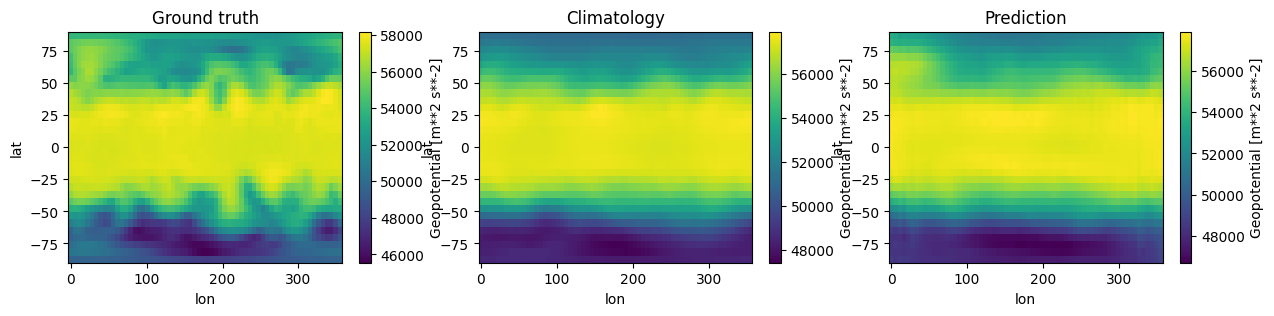

In [21]:
# Note first you need to modify your predictions so they are an xarray instead of a numpy array
# This way you can access the latitude, longitude and time for each point in the array

# We do this by taking a copy of the original z500 object which has the correct time,
# latitude and longitude, and replacing the data in this array with the predictions
pred_xarray = z500.z.sel(time=test_years).isel(time=slice(lead_time_steps, None)).copy()
print('PRED XARRAY',pred_xarray)

pred_xarray.data = pred_test

print(pred_xarray)

import matplotlib.pyplot as plt

t = xr.DataArray(np.datetime64('2017-10-01T00'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

z500.z.sel(time=t).plot(ax=ax1)
ax1.set_title('Ground truth')

clim.z.sel(dayofyear=t.dt.dayofyear).plot(ax=ax2)
ax2.set_title('Climatology')

pred_xarray.sel(time=t).plot(ax=ax3)
ax3.set_title('Prediction')

The prediction is a lot smoother compared to the ground truth, almost as smooth as climatology.

## Ideas and Additional Exercises

The model we built isn't particularly good. How could we make it better? Here are some ideas to try.

- Make the neural net bigger/smaller?

  We provide the following function for you to easily construct a neural network with more layers:

```
def build_model_cnn(no_of_layers):
    """Fully convolutional network"""
    x = input = keras.layers.Input(shape=(32, 64, 1))
    x = Conv2D(64, 5, padding = 'same')(x)    
    for i in range(no_of_layers):
        x = Conv2D(64, 5, padding = 'same')(x)
        x = tf.keras.layers.Activation('ReLU')(x)
    output = Conv2D(1, 5, padding = 'same')(x)
    model = tf.keras.models.Model(input, output)
    model.compile(keras.optimizers.Adam(1e-4), 'mse')
    print(model.summary())
    return model
```

- Add more variables, for example 850hPa temperature, which is available, check: https://github.com/pangeo-data/WeatherBench
- Currently, the convolutions do not wrap around the Earth. You could implement periodic convolutions, see [here](https://github.com/pangeo-data/WeatherBench/blob/master/src/train_nn.py#L102).